## Particle tracking through a steady-state flow field on a structured grid

Application of a MODFLOW 6 particle-tracking (PRT) model to solve example 1 from the MODPATH 7 documentation.

### Particle-tracking problem setup

Imports

In [1]:
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
import flopy
import numpy as np

Append to system path to include the common subdirectory

In [2]:
sys.path.append(os.path.join("..", "common"))

Import common functionality

In [3]:
import config
from figspecs import USGSFigure

In [4]:
#mf6exe = os.path.abspath(config.mf6_exe)
# issue: temporary mf6exe path
mf6exe = "C:\\Users\\aprovost\\Documents\\ACTIVE\\modflow6\\bin\\mf6"
exe_name_mp7 = config.mp7_exe

Set figure properties specific to this problem

In [5]:
figure_size = (12.5, 4.5)

Base simulation and model name and workspace

In [6]:
sim_name = "mp7-p01"
example_name = "ex-prt-" + sim_name

ws = config.base_ws

Simulation and model names, filenames, and workspaces

In [7]:
nm_mf6 = sim_name
nm_prt = sim_name + "_prt"
nm_mp7 = sim_name

headfile = "{}.hds".format(nm_mf6)
budgetfile = "{}.cbb".format(nm_mf6)
budgetfile_prt = "{}.cbb".format(nm_prt)

sim_ws = os.path.join(ws, example_name)
mp7_ws = os.path.join(sim_ws, "mp7")

Model units

In [8]:
length_units = "feet"
time_units = "days"

Time discretization parameters

In [9]:
nper, nstp, perlen, tsmult = 1, 1, 1.0, 1.0

MODFLOW 6 flow model parameters

In [10]:
# Grid
nlay, nrow, ncol = 3, 21, 20
delr = delc = 500.0
top = 400.0
botm = [220.0, 200.0, 0.0]

# Layer types
laytyp = [1, 0, 0]

# Conductivities
kh = [50.0, 0.01, 200.0]
kv = [10.0, 0.01, 20.0]

# Well
wel_loc = (2, 10, 9)
wel_q = -150000.0

# Recharge
rch = 0.005
rch_iface = 6
rch_iflowface = -1

# River
riv_h = 320.0
riv_z = 317.0
riv_c = 1.0e5
riv_iface = 6
riv_iflowface = -1

MODFLOW 6 flow model package data

In [11]:
# Well package
wd = [(wel_loc, wel_q)]

# River package
rd = []
for i in range(nrow):
    rd.append([(0, i, ncol - 1), riv_h, riv_c, riv_z, riv_iface, riv_iflowface])

Shared MODFLOW 6 PRT and MODPATH 7 particle-tracking model parameters

In [12]:
# Porosity
porosity = 0.1

# Zones
def_zone = 1
wel_zone = 2
zones_lay1 = def_zone
zones_lay2 = def_zone
zones_lay3 = np.full((nrow, ncol), def_zone, dtype=np.int32)
zones_lay3[wel_loc[1:]] = wel_zone

# Starting location template size for example 1B;
# in the original example, there is initially a
# 3x3 array of particles in each cell in layer 1;
# in this example, there is initially one
# particle in each cell in layer 1; the original
# 3x3 particle arrays can be restored simply by
# setting sloc_tmpl_size below to 3 instead of 1.
sloc_tmpl_size = 1

MODPATH 7 model parameters

In [13]:
# Zones
zones = [zones_lay1, zones_lay2, zones_lay3]

# Default iface
defaultiface = {"RCH": 6, "EVT": 6}

Particle release point data for the MODFLOW 6 PRT particle-tracking model

In [14]:
# Example 1A
releasepts = {}
releasepts['1A'] = []
zrpt = top
k = 0
j = 2
for i in range(nrow):
    nrpt = i
    xrpt = (j + 0.5) * delr
    yrpt = (nrow - i - 0.5) * delc
    rpt = [nrpt, k, i, j, xrpt, yrpt, zrpt]
    releasepts['1A'].append(rpt)

In [15]:
# Example 1B
releasepts['1B'] = []
ndivc = sloc_tmpl_size
ndivr = sloc_tmpl_size
deldivc = delc / ndivc
deldivr = delr / ndivr
k = 0
zrpt = top
nrpt = -1
for i in range(nrow):
    y0 = (nrow - i - 1) * delc
    for j in range(ncol):
        x0 = j * delr
        for idiv in range(ndivc):
            dy = (idiv + 0.5) * deldivc
            yrpt = y0 + dy
            for jdiv in range(ndivr):
                dx = (jdiv + 0.5) * deldivr
                xrpt = x0 + dx
                nrpt += 1
                rpt = [nrpt, k, i, j, xrpt, yrpt, zrpt]
                releasepts['1B'].append(rpt)

Particle data for the MODPATH 7 model

In [16]:
# Example 1A
plocs = []
pids = []
for idx in range(nrow):
    plocs.append((0, idx, 2))
    pids.append(idx)
# issue(flopyex): in the flopy example this notebook is based on,
#  localz is not set to 1.0 like in the MODPATH examples doc,
#  so it defaults to 0.5, but it shouldn't really matter because
#  the particle gets placed at the water table anyway
part0 = flopy.modpath.ParticleData(
    plocs, drape=0, structured=True, particleids=pids, localz=1.0
)

In [17]:
# Example 1B
divs = sloc_tmpl_size
locs1b = [[0, 0, 0, 0, nrow - 1, ncol - 1]]
sd = flopy.modpath.CellDataType(
    drape=0, columncelldivisions=1, rowcelldivisions=1, layercelldivisions=1
)
sd = flopy.modpath.FaceDataType(
    drape=0,
    verticaldivisions1=0, horizontaldivisions1=0,
    verticaldivisions2=0, horizontaldivisions2=0,
    verticaldivisions3=0, horizontaldivisions3=0,
    verticaldivisions4=0, horizontaldivisions4=0,
    rowdivisions5=0, columndivisions5=0,
    rowdivisions6=divs, columndivisions6=divs
)
p = flopy.modpath.LRCParticleData(
    subdivisiondata=[sd], lrcregions=[locs1b]
)

Information used to extract and plot model results

In [18]:
# Get well and river cell numbers
nodes = {}
k, i, j = wel_loc
nodes['well'] = ncol * (nrow * k + i) + j
nodes['river'] = []
for rivspec in rd:
    k, i, j = rivspec[0]
    node = ncol * (nrow * k + i) + j
    nodes['river'].append(node)

# Colors by capture destination
colordest = dict.fromkeys(['well', 'river'], "blue")
colordest['well'] = "red"

### Functions to build, write, run, and plot models

A MODFLOW 6 flopy GWF + PRT simulation object (sim) and a MODPATH 7 flopy simulation object (mp7) are returned


In [19]:
def build_model(example_name):
    print("Building models...{}".format(example_name))

    # ===============================
    # Create the MODFLOW 6 simulation
    # ===============================
    
    # Instantiate the MODFLOW 6 simulation object
    sim = flopy.mf6.MFSimulation(
        sim_name=nm_mf6, exe_name=mf6exe, version="mf6", sim_ws=sim_ws
    )

    # Instantiate the MODFLOW 6 temporal discretization package
    pd = (perlen, nstp, tsmult)
    tdis = flopy.mf6.modflow.mftdis.ModflowTdis(
        sim, pname="tdis", time_units="DAYS", nper=nper, perioddata=[pd]
    )

    # -------------------
    # Build the GWF model
    # -------------------

    # Instantiate the MODFLOW 6 gwf (groundwater-flow) model
    model_nam_file = "{}.nam".format(nm_mf6)
    gwf = flopy.mf6.ModflowGwf(
        sim, modelname=nm_mf6, model_nam_file=model_nam_file, save_flows=True
    )

    # Instantiate the MODFLOW 6 gwf discretization package
    dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
        gwf,
        pname="dis",
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        length_units="FEET",
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )

    # Instantiate the MODFLOW 6 gwf initial conditions package
    ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname="ic", strt=top)

    # Instantiate the MODFLOW 6 gwf node property flow package
    npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(
        gwf, pname="npf", icelltype=laytyp, k=kh, k33=kv,
        save_saturation=True, save_specific_discharge=True,
    )

    # Instantiate the MODFLOW 6 gwf recharge package
    flopy.mf6.modflow.mfgwfrcha.ModflowGwfrcha(
        gwf, recharge=rch,
        auxiliary=["iface", "iflowface"], aux=[rch_iface, rch_iflowface],
    )

    # Instantiate the MODFLOW 6 gwf well package
    flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(
        gwf, maxbound=1, stress_period_data={0: wd}
    )

    # Instantiate the MODFLOW 6 gwf river package
    flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(
        gwf, auxiliary=["iface", "iflowface"], stress_period_data={0: rd}
    )

    # Instantiate the MODFLOW 6 gwf output control package
    head_record = [headfile]
    budget_record = [budgetfile]
    saverecord = [("HEAD", "ALL"), ("BUDGET", "ALL")]
    oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(
        gwf,
        pname="oc",
        saverecord=saverecord,
        head_filerecord=head_record,
        budget_filerecord=budget_record,
    )

    # -------------------
    # Build the PRT model
    # -------------------

    # Instantiate the MODFLOW 6 prt model
    prt = flopy.mf6.ModflowPrt(
        sim, modelname=nm_prt, model_nam_file="{}.nam".format(nm_prt)
    )

    # Instantiate the MODFLOW 6 prt discretization package
    dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(
        prt, pname="dis",
        nlay=nlay, nrow=nrow, ncol=ncol,
        length_units="FEET",
        delr=delr, delc=delc,
        top=top, botm=botm,
    )

    # Instantiate the MODFLOW 6 prt model input package
    mip = flopy.mf6.ModflowPrtmip(prt, pname="mip", porosity=porosity)

    # Instantiate the MODFLOW 6 prt particle release point (prp) package
    # for example 1A
    nreleasepts1a = len(releasepts['1A'])
    pd = {0: ["FIRST"],}
    prp1a = flopy.mf6.ModflowPrtprp(
        prt, pname="prp1a", filename="{}_1a.prp".format(nm_prt),
        nreleasepts=nreleasepts1a, packagedata=releasepts['1A'],
        perioddata=pd,
    )

    # Instantiate the MODFLOW 6 prt particle release point (prp) package
    # for example 1B
    nreleasepts1b = len(releasepts['1B'])
    pd = {0: ["FIRST"],}
    prp1b = flopy.mf6.ModflowPrtprp(
        prt, pname="prp1b", filename="{}_1b.prp".format(nm_prt),
        nreleasepts=nreleasepts1b, packagedata=releasepts['1B'],
        perioddata=pd,
    )

    # Instantiate the MODFLOW 6 prt output control package
    budget_record = [budgetfile_prt]
    oc = flopy.mf6.ModflowPrtoc(
        prt,
        pname="oc",
        budget_filerecord=budget_record,
        saverecord=[("BUDGET", "ALL")],
    )

    # Instantiate the MODFLOW 6 prt flow model interface
    fmi = flopy.mf6.ModflowPrtfmi(prt)

    # Create the MODFLOW 6 gwf-prt model exchange
    gwfprt = flopy.mf6.ModflowGwfprt(
        sim, exgtype="GWF6-PRT6",
        exgmnamea=nm_mf6, exgmnameb=nm_prt,
        filename="{}.gwfprt".format(nm_mf6),
    )
    
    #--------------------------------------------------
    # Create solutions for the models in the simulation
    #--------------------------------------------------

    # Create an iterative model solution (IMS) for the MODFLOW 6 gwf model
    ims = flopy.mf6.ModflowIms(
        sim, pname="ims",
        complexity="SIMPLE",
        outer_dvclose=1e-6, inner_dvclose=1e-6,
        rcloserecord=1e-6,
    )

    # Create an explicit model solution (EMS) for the MODFLOW 6 prt model
    # issue(flopy): using IMS until mfsimulation.py is updated for EMS by Scott
    # issue(mf6): code is kluged to create EMS if first model in IMS is a PRT
    ems = flopy.mf6.ModflowIms(
        sim, pname="ems",
        outer_maximum=100,
        filename="{}.ems".format(nm_prt),
    )
    sim.register_ims_package(ems, [prt.name])

    # ===============================
    # Create the MODPATH 7 simulation
    # ===============================

    # Instantiate the MODPATH 7 simulation object
    bfile = os.path.join("..\\..\\", sim_ws, budgetfile)
    hfile = os.path.join("..\\..\\", sim_ws, headfile)
    mp7 = flopy.modpath.Modpath7(
        modelname=nm_mp7, flowmodel=gwf, exe_name=exe_name_mp7, model_ws=mp7_ws,
        budgetfilename=bfile, headfilename=hfile
    )

    # Instantiate the MODPATH 7 basic data
    mpbas = flopy.modpath.Modpath7Bas(mp7, porosity=porosity, defaultiface=defaultiface)

    # Instantiate the MODPATH 7 particle groups
    pg1a = flopy.modpath.ParticleGroup(
        particlegroupname="PG1A", particledata=part0, filename=sim_name + "a.sloc"
    )
    pg1b = flopy.modpath.ParticleGroupLRCTemplate(
        particlegroupname="PG1B", particledata=p, filename=sim_name + "b.sloc"
    )

    # Instantiate the MODPATH 7 simulation data
    mpsim = flopy.modpath.Modpath7Sim(
        mp7,
        simulationtype="combined",
        trackingdirection="forward",
        weaksinkoption="pass_through",
        weaksourceoption="pass_through",
        budgetoutputoption="summary",
        referencetime=[0, 0, 0.0],
        stoptimeoption="extend",
        timepointdata=[500, 1000.0],
        zonedataoption="on",
        zones=zones,
        particlegroups=[pg1a, pg1b],
    )
    
    #=======================
    # Return the simulations
    #=======================

    return sim, mp7

Function to write model files

In [20]:
def write_model(sim, mp7, silent=True):
    if config.writeModel:
        sim.write_simulation(silent=silent)
        mp7.write_input()
    return

Function to run the models; True is returned if the model runs successfully

In [21]:
# temporary utility function
def copy_grb_tdis():

    import shutil

    fname = os.path.join(nm_mf6 + ".dis.grb")
    filemf6 = os.path.join(sim_ws, fname)
    filemp7 = os.path.join(mp7_ws, fname)
    cp = shutil.copyfile(filemf6, filemp7)

    fname = os.path.join(nm_mf6 + ".tdis")
    filemf6 = os.path.join(sim_ws, fname)
    filemp7 = os.path.join(mp7_ws, fname)
    cp = shutil.copyfile(filemf6, filemp7)

    return

In [22]:
@config.timeit
def run_model(sim, mp7, silent=True):
    success = True
    if config.runModel:
        # Run MODFLOW 6 simulation
        success_run = False
        success_run, buff = sim.run_simulation(silent=silent)
        if not success_run:
            print(buff)
            success = success_run
        # issue(flopy): has only flopy-determined paths/names for the GRB and TDIS files,
        #   for both mf6 output and mp7 input, so here they are being copied over from the
        #   mf6 folder to the mp7 folder using a temporary utility function
        copy_grb_tdis()
        # Run MODPATH 7 simulation
        success_run = False
        success_run, buff = mp7.run_model(silent=silent)
        if not success_run:
            print(buff)
            success = success_run
    return success

Function to plot the model results

In [23]:
# Utility function for reading and storing MODFLOW 6 PRT pathlines
# issue(flopy): need general routine for loading prt pathline data
def load_mf6pathlines(cbb):

    ncpl = nrow * ncol
    dtype={'names':['x','y','z','time','k','particleid'],
           'formats':['<f4','<f4','<f4','<f4','<i4','<i4'],
          }
    upn = cbb.get_unique_package_names(decode=True)
    times = cbb.get_times()

    # Extract pathline data to a dictionary keyed on subproblem (1A or 1B)
    # and capture destination (well or river)
    mf6pathlines = {}
    for prpnam in upn:
        subprob = prpnam.strip()[-2:]
        pdict = {}
        # For each time, read and parse particle data written by the prp
        # and add it to a dictionary keyed on a particle identifier consisting
        # of release point number and release time
        for totim in times:
            data = cbb.get_data(text='DATA-PRTCL', paknam=prpnam, totim=totim)
            for ploc in data[0]:
                # Particle data read from the binary output file are in terms
                # of one-based indexing; will convert to zero-based indexing
                irpt, node, xp, yp, zp, trelease, ttrack = [ploc[i] for i in (0, 1, 3, 4, 5, 6, 7)]
                irpt -= 1
                node -= 1
                kp = node // ncpl
                # issue(mf6): particle ids not assigned yet in mf6
                pathpoint = (xp, yp, zp, ttrack, kp, 0)
                key = (irpt, trelease)
                # Note that repeat locations written for terminated particles
                # are not filtered out here, though they could be
                if key not in pdict:
                    pdict[key] = [pathpoint]
                else:
                    pdict[key].append(pathpoint)
        # Sort the dictionary into separate dictionaries of formatted arrays
        # for pathlines ending at the well and pathlines ending at the river
        mf6pathlines[(subprob, 'well')] = []
        mf6pathlines[(subprob, 'river')] = []
        for key in pdict:
            path = np.core.records.fromarrays(np.array(pdict[key]).T, dtype=dtype)
            # issue(mf6): zone info not stored with particle locations, so using
            #   layer number to determine endpoint zone (well or river) in this problem
            if path['k'][-1] == 2:
                mf6pathlines[(subprob, 'well')].append(path)
            else:
                mf6pathlines[(subprob, 'river')].append(path)
                    
    # Return mf6pathlines
    return mf6pathlines

In [24]:
# Utility function for reading and storing MODFLOW 6 PRT endpoint data
# issue(flopy): need general routine for loading prt endpoint data
def load_mf6endpointdata(cbb):

    ncpl = nrow * ncol
    dtype={'names':['time0','time',
                    'node0','k0','x0','y0','z0',
                    'node','k','x','y','z',
                    'zone'],
           'formats':['<f4','<f4',
                      '<i4','<i4','<f4','<f4','<f4',
                      '<i4','<i4','<f4','<f4','<f4',
                      '<i4'],
          }
    upn = cbb.get_unique_package_names(decode=True)
    times = cbb.get_times()

    # Extract endpoint data to a dictionary keyed on subproblem (1A or 1B)
    # and capture destination (well or river)
    mf6endpointdata = {}
    for prpnam in upn:
        subprob = prpnam.strip()[-2:]
        edict = {}
        # For each time, read and parse particle data written by the prp
        # and store it in a dictionary keyed on a particle identifier consisting
        # of release point number and release time; later data overwrite earlier
        # data for the same key, ultimately resulting in the endpoint being stored;
        # alternatively, could read backwards in time, but would still need to
        # deal with repeat locations for terminated particles
        for totim in times:
            data = cbb.get_data(text='DATA-PRTCL', paknam=prpnam, totim=totim)
            for ploc in data[0]:
                # Particle data read from the binary output file are in terms
                # of one-based indexing; will convert to zero-based indexing
                irpt, node, xp, yp, zp, trelease, ttrack = [ploc[i] for i in (0, 1, 3, 4, 5, 6, 7)]
                irpt -= 1
                node -= 1
                key = (subprob, irpt, trelease)
                # To facilitate meaningful travel times, filter out repeat locations
                # written for terminated particles
                if (key not in edict) or \
                node != edict[key][7] or xp != edict[key][9] or \
                yp != edict[key][10] or zp != edict[key][11]:
                    rpt = releasepts[subprob][irpt]
                    krls, irls, jrls = [rpt[i] for i in (1, 2, 3)]
                    noderls = ncol * (nrow * krls + irls) + jrls
                    xrls = rpt[4]
                    yrls = rpt[5]
                    zrls = rpt[6]
                    kp = node // ncpl
                    # issue(mf6): zone info not stored with particle locations, so using
                    #   layer number to determine endpoint zone (well or river) in this problem
                    if kp == 2:
                        zone = 1
                    else:
                        zone = 0
                    # issue(mf6): particle ids not assigned yet in mf6
                    edict[key] = (trelease, ttrack,
                                  noderls, krls, xrls, yrls, zrls,
                                  node, kp, xp, yp, zp,
                                  zone)
        # Sort the dictionary into separate dictionaries of formatted arrays
        # for endpoints at the well and endpoints at the river
        mf6endpointdata[(subprob, 'well')] = []
        mf6endpointdata[(subprob, 'river')] = []
        for key in edict:
            if edict[key][-1] == 1:
                mf6endpointdata[(subprob, 'well')].append(edict[key])
            else:
                mf6endpointdata[(subprob, 'river')].append(edict[key])
        mf6endpointdata[(subprob, 'well')] = np.rec.array(mf6endpointdata[(subprob, 'well')], dtype=dtype)
        mf6endpointdata[(subprob, 'river')] = np.rec.array(mf6endpointdata[(subprob, 'river')], dtype=dtype)

    # Merge endpoint data for particles that terminate in the well
    # and particles that terminate in the river
    for subprob in ['1A', '1B']:
        mf6endpointdata[(subprob, 'all')] = np.concatenate((mf6endpointdata[(subprob, 'well')],
                                                            mf6endpointdata[(subprob, 'river')]))

    # Return mf6endpointdata
    return mf6endpointdata

In [25]:
# Utility function for reading and storing MODPATH 7 pathlines
def load_mp7pathlines(plf):

    # Extract pathline data to a dictionary keyed on subproblem (1A or 1B)
    # and capture destination (well or river)
    mp7pathlines = {}
    for dest in ['well', 'river']:
        pdata = plf.get_destination_pathline_data(nodes[dest], to_recarray=True)
        for pgidx, subprob in enumerate(['1A', '1B']):
            mp7pathlines[(subprob, dest)] = np.array([point for point in pdata
                                                      if point['particlegroup'] == pgidx],
                                                     dtype=pdata.dtype)

    # Return mp7pathlines
    return mp7pathlines

In [26]:
# Utility function for reading and storing MODPATH 7 endpoint data
def load_mp7endpointdata(epf):

    # Extract endpoint data to a dictionary keyed on subproblem (1A or 1B)
    # and capture destination (well or river)
    mp7endpointdata = {}
    for dest in ['well', 'river']:
        epd = epf.get_destination_endpoint_data(dest_cells=nodes[dest])
        for pgidx, subprob in enumerate(['1A', '1B']):
            mp7endpointdata[(subprob, dest)] = np.array([point for point in epd
                                                         if point['particlegroup'] == pgidx],
                                                         dtype=epd.dtype)

    # Merge endpoint data for particles that terminate in the well
    # and particles that terminate in the river
    for subprob in ['1A', '1B']:
        mp7endpointdata[(subprob, 'all')] = np.concatenate((mp7endpointdata[(subprob, 'well')],
                                                            mp7endpointdata[(subprob, 'river')]))

    # Return mp7endpointdata
    return mp7endpointdata

In [27]:
# Utility function for extracting MODFLOW 6 PRT results
def get_mf6_results():
    
    import flopy.utils.binaryfile as bf

    # Prt budget file
    fpth = os.path.join(sim_ws, budgetfile_prt)
    cbb = bf.CellBudgetFile(fpth)

    # Load pathlines and endpoint data
    mf6pathlines = load_mf6pathlines(cbb)
    mf6endpointdata = load_mf6endpointdata(cbb)

    return mf6pathlines, mf6endpointdata

In [28]:
# Utility function for extracting MODPATH 7 results
def get_mp7_results():
    
    # Load pathlines
    fpth = os.path.join(mp7_ws, nm_mp7 + ".mppth")
    plf = flopy.utils.PathlineFile(fpth)
    mp7pathlines = load_mp7pathlines(plf)
    
    # Load endpoint data
    fpth = os.path.join(mp7_ws, nm_mp7 + ".mpend")
    epf = flopy.utils.EndpointFile(fpth)
    mp7endpointdata = load_mp7endpointdata(epf)

    return mp7pathlines, mp7endpointdata

In [29]:
# Utility function for plotting pathlines optionally colored
# by capture destination
def plot_pathlines(ax, gwf, pathlines, subprob, plottitle, **kwargs):

    ax.set_title(plottitle, fontsize=12)
    ax.set_aspect('equal')
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
    mm.plot_grid(lw=0.5)
    
    for dest in ['well', 'river']:
        label = None
        if 'colordest' in kwargs:
            # Use colordest to color pathlines by capture destination
            color = kwargs['colordest'][dest]
            label = "captured by " + dest
        elif 'color' in kwargs:
            # Use the specified color for all pathlines
            color = kwargs['color']
        else:
            # Use a default color for all pathlines
            color = "blue"
        mm.plot_pathline(
            pathlines[(subprob, dest)], layer="all",
            color=color, label=label)
        if label != None:
            ax.legend()

    return

In [30]:
# Utility function for plotting particle starting points colored
# by capture destination or travel time to capture
def plot_startpts(ax, gwf, endpointdata, subprob, plottitle, **kwargs):

    ax.set_title(plottitle, fontsize=12)
    ax.set_aspect('equal')
    mm = flopy.plot.PlotMapView(model=gwf, ax=ax)
    mm.plot_grid(lw=0.5)
    startingpoint_markersize = 5

    if 'colordest' in kwargs:
        # Use colordest to color starting points by capture destination
        for dest in ['well', 'river']:
            color = kwargs['colordest'][dest]
            label = "captured by " + dest
            # issue(flopy): since plot_endpoint always sets kwarg c to something,
            #   kwarg color conflicts with c if you try to set color; temporarily
            #   modified plot_endpoint (map.py) in my flopy installation to check
            #   for color before setting default for c, so there's no conflict;
            #   will ask Josh about implementing this permanently
            mm.plot_endpoint(
                endpointdata[(subprob, dest)], direction="starting",
                s=startingpoint_markersize, color=color,
                label=label
            )
            ax.legend()
    else:
        # Color starting points by travel time to capture
        mm.plot_endpoint(
            endpointdata[(subprob, 'all')], direction="starting",
            s=startingpoint_markersize, colorbar=True, shrink=0.25
        )
    
    return

In [31]:
def plot_results(sim, mp7, idx):
    
    # get results
    mf6pathlines, mf6endpointdata = get_mf6_results()
    mp7pathlines, mp7endpointdata = get_mp7_results()

    # get gwf model
    gwf = sim.get_model(nm_mf6)

    # ==========
    # Example 1A
    # ==========

    # --------------------------------------------------------
    # Pathlines colored by capture destination (well or river)
    # --------------------------------------------------------

    # initialize plot
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figure_size)
    plt.suptitle(t='Example 1A - Pathlines colored by capture destination (well or river)',
                 fontsize=14, y=1.05)
    axes = axes.flatten()

    # MODFLOW 6 PRT
    ax = axes[0]
    plot_pathlines(ax, gwf, mf6pathlines, '1A', 'MODFLOW 6 PRT', colordest=colordest)

    # MODPATH 7
    ax = axes[1]
    plot_pathlines(ax, gwf, mp7pathlines, '1A', 'MODPATH 7', colordest=colordest)
    # issue: the pathlines in the right-hand plot appear not to go
    #   go quite as far, despite their being the same as the ones
    #   on the left; axis scaling issue?

    # Save figure
    if config.plotSave:
        fpth = os.path.join(
            "..", "figures", "{}-conc{}".format(sim_name, config.figure_ext)
        )
        fig.savefig(fpth)

    # ==========
    # Example 1B
    # ==========

    # --------------------------------------------------------
    # Pathlines colored by capture destination (well or river)
    # --------------------------------------------------------

    # initialize plot
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figure_size)
    plt.suptitle(t='Example 1B - Pathlines colored by capture destination (well or river)',
                 fontsize=14, y=1.05)
    axes = axes.flatten()

    # MODFLOW 6 PRT
    ax = axes[0]
    plot_pathlines(ax, gwf, mf6pathlines, '1B', 'MODFLOW 6 PRT', colordest=colordest)

    # MODPATH 7
    ax = axes[1]
    plot_pathlines(ax, gwf, mp7pathlines, '1B', 'MODPATH 7', colordest=colordest)

    # Save figure
    if config.plotSave:
        fpth = os.path.join(
            "..", "figures", "{}-conc{}".format(sim_name, config.figure_ext)
        )
        fig.savefig(fpth)

    # -----------------------------------------------------------------------
    # Particle starting points colored by capture destination (well or river)
    # -----------------------------------------------------------------------

    # initialize plot
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figure_size)
    plt.suptitle(t='Example 1B - Particle starting points colored by capture destination (well or river)',
                 fontsize=14, y=1.05)
    axes = axes.flatten()

    # MODFLOW 6 PRT
    ax = axes[0]
    plot_startpts(ax, gwf, mf6endpointdata, '1B', 'MODFLOW 6 PRT', colordest=colordest)

    # MODPATH 7
    ax = axes[1]
    plot_startpts(ax, gwf, mp7endpointdata, '1B', 'MODPATH 7', colordest=colordest)

    # Save figure
    if config.plotSave:
        fpth = os.path.join(
            "..", "figures", "{}-conc{}".format(sim_name, config.figure_ext)
        )
        fig.savefig(fpth)

    # ----------------------------------------------------------
    # Particle starting points colored by travel time to capture
    # ----------------------------------------------------------

    # initialize plot
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=figure_size)
    plt.suptitle(t='Example 1B - Particle starting points colored by travel time to capture',
                 fontsize=14, y=1.05)
    axes = axes.flatten()

    # MODFLOW 6 PRT
    ax = axes[0]
    plot_startpts(ax, gwf, mf6endpointdata, '1B', 'MODFLOW 6 PRT')

    # MODPATH 7
    ax = axes[1]
    plot_startpts(ax, gwf, mp7endpointdata, '1B', 'MODPATH 7')

    # Save figure
    if config.plotSave:
        fpth = os.path.join(
            "..", "figures", "{}-conc{}".format(sim_name, config.figure_ext)
        )
        fig.savefig(fpth)
        
    return

Function that wraps all of the steps for each scenario.

1. build_model,
2. write_model,
3. run_model, and
4. plot_results.

In [32]:
def scenario(idx, silent=True):
    sim, mp7 = build_model(example_name)
    write_model(sim, mp7, silent=silent)
    success = run_model(sim, mp7, silent=silent)
    if success:
        plot_results(sim, mp7, idx)

### Particle-tracking example problem

Plots comparing MODFLOW 6 PRT and MODPATH 7 results

Building models...ex-prt-mp7-p01
run_model  1,942.85 ms


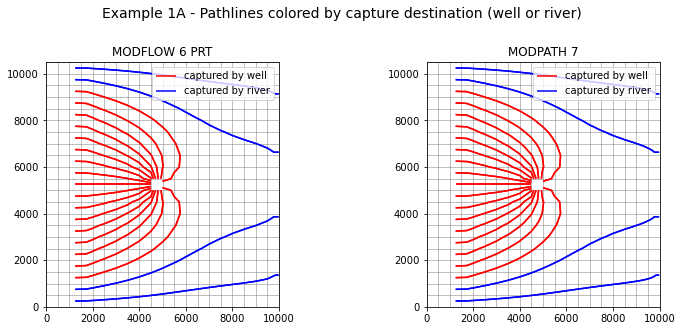

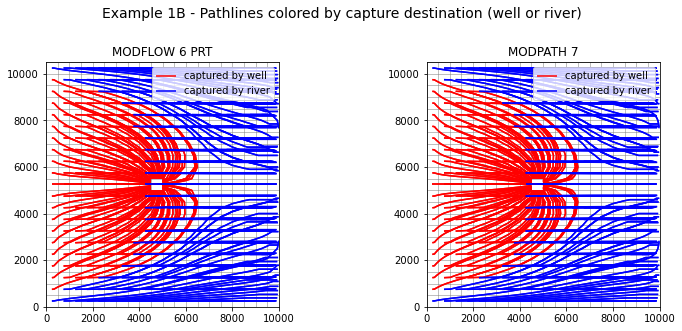

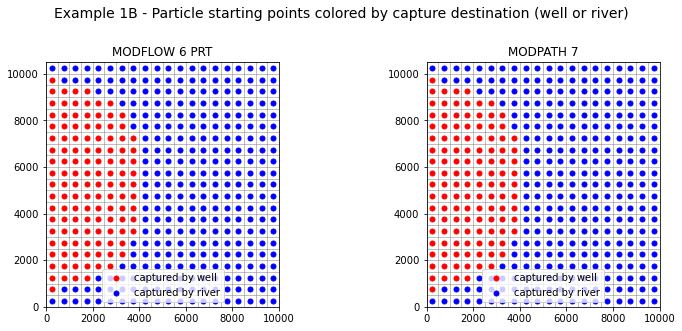

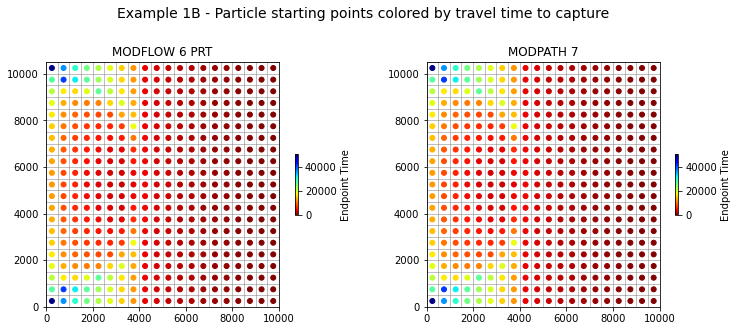

In [33]:
# Subproblems 1A and 1B are solved by a single MODFLOW 6 run and a single MODPATH 7 run,
# so they are included under one "scenario"; each of the two subproblems is represented
# by its own particle release package (for MODFLOW 6) or particle group (for MODPATH 7)
scenario(0)